# 图数据基本属性

x found in data
edge_index found in data
tensor([[-1.,  1.],
        [ 0.,  1.],
        [ 1.,  1.]])


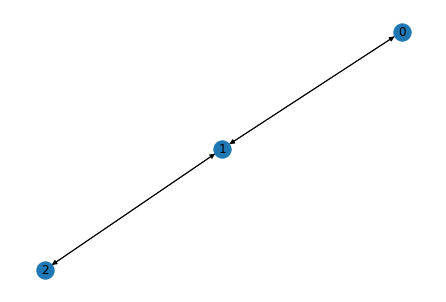

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
from networkx import draw_kamada_kawai
import matplotlib.pyplot as plt

## 定义节点和边
# 定义节点 需要传入一个 list of list，子 list 表示节点上的特征
x = torch.tensor([[-1,1], [0,1], [1,1]], dtype=torch.float)
# 定义边 需要传入一个 list of list，第一个list是边起点的集合，第二个list是边终点的集合
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)


data = Data(x=x, edge_index=edge_index)
device = torch.device('cpu')
data = data.to(device)

for key, item in data:
    print(f'{key} found in data')

print(data['x'])

dg = convert.to_networkx(data)
draw_kamada_kawai(dg,with_labels=True)
plt.show()




# 图数据集

600


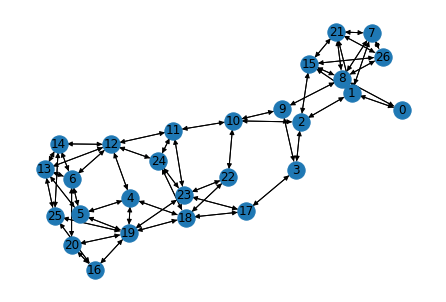

Data(edge_index=[2, 114], x=[27, 3], y=[1])


In [2]:
from torch_geometric.datasets import TUDataset
from random import randint

# ENZYMES 这个数据集有 600 张图
dataset = TUDataset(root='../data/ENZYMES', name='ENZYMES')
print(len(dataset))

# dataset 本质上是一个 list，每个位置存储一张 图
index = randint(0,600)
dg = convert.to_networkx(dataset[index])
draw_kamada_kawai(dg,with_labels=True)
plt.show()
print(dataset[index])

In [3]:
from torch_geometric.datasets import Planetoid

# Cora 这个数据集有 1 张图
dataset = Planetoid(root='../data/Cora', name='Cora')
print(len(dataset))
data = dataset[0]
print(data)


1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# Batch
一个 batch 就是一组图。

In [4]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='../data/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for data  in loader:
    print(data )




# Cora 这个数据集有 1 张图
dataset = Planetoid(root='../data/Cora', name='Cora')
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for data  in loader:
    print(data )


DataBatch(edge_index=[2, 4398], x=[1156, 21], y=[32], batch=[1156], ptr=[33])
DataBatch(edge_index=[2, 3884], x=[1034, 21], y=[32], batch=[1034], ptr=[33])
DataBatch(edge_index=[2, 3666], x=[924, 21], y=[32], batch=[924], ptr=[33])
DataBatch(edge_index=[2, 4278], x=[1152, 21], y=[32], batch=[1152], ptr=[33])
DataBatch(edge_index=[2, 3748], x=[986, 21], y=[32], batch=[986], ptr=[33])
DataBatch(edge_index=[2, 4014], x=[1019, 21], y=[32], batch=[1019], ptr=[33])
DataBatch(edge_index=[2, 3670], x=[978, 21], y=[32], batch=[978], ptr=[33])
DataBatch(edge_index=[2, 4364], x=[1141, 21], y=[32], batch=[1141], ptr=[33])
DataBatch(edge_index=[2, 4012], x=[1034, 21], y=[32], batch=[1034], ptr=[33])
DataBatch(edge_index=[2, 3384], x=[866, 21], y=[32], batch=[866], ptr=[33])
DataBatch(edge_index=[2, 4434], x=[1108, 21], y=[32], batch=[1108], ptr=[33])
DataBatch(edge_index=[2, 3602], x=[942, 21], y=[32], batch=[942], ptr=[33])
DataBatch(edge_index=[2, 3880], x=[1059, 21], y=[32], batch=[1059], ptr=[3

# 自定义数据集
没必要非得弄个 dataset 类...

最终是将 Data 类输入网络进行训练，可以和 gcndemo.py 对比一下

In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import convert
from networkx import draw_kamada_kawai
import matplotlib.pyplot as plt
## 生成数据 创建一个简单图 相邻节点相连
node_num = 10
feature_num = 3
class_num = 5
myX = torch.rand(node_num,feature_num , dtype=torch.float32)
print(myX.shape)

myY = torch.randint(class_num,(node_num,) , dtype=torch.long)


# 定义边 相邻的节点相连接
my_edge_index = torch.zeros(2,(node_num-1)*2, dtype=torch.long)
for i in range(0,(node_num-1)*2-1,2):
    # 第一条边
    ind = i//2
    my_edge_index[0,i] = ind
    my_edge_index[1,i] = ind+1
    # 第二条边
    my_edge_index[0,i+1] = ind+1
    my_edge_index[1,i+1] = ind


# for i in range(0,my_edge_index.shape[1]):
#     print(my_edge_index[:,i])

data = Data(x=myX, y=myY, edge_index=my_edge_index)

# dg = convert.to_networkx(data)
# draw_kamada_kawai(dg,with_labels=True)
# plt.show()

## 将数据存储为文件
import os
# root = '.'
# dataname = "myG"
# os.makedirs(os.path.join(root,dataname,'raw'))
# rawPath = os.path.join(root,dataname,'raw',"myG.pt")
# torch.save(data,rawPath)

torch.Size([10, 3])


In [6]:
## 用 GCN 网络进行学习
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self,feature_num,class_num):
        super().__init__()
        self.conv1 = GCNConv(feature_num, 16)
        self.conv2 = GCNConv(16, class_num)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(feature_num,class_num).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    if (epoch+1) % 100 == 0:
        print(out,data.y)
    loss.backward()
    optimizer.step()


model.eval()
pred = model(data).argmax(dim=1)
correct = (pred == data.y).sum()
acc = int(correct) / int(data.y.shape[0])
print(f'Accuracy: {acc:.4f}')



tensor([[-2.3169, -1.6287, -2.2617, -1.0431, -1.3915],
        [-2.1162, -1.7362, -2.2680, -1.2425, -1.1674],
        [-2.0030, -1.7328, -2.1784, -1.5269, -1.0277],
        [-1.1698, -1.8418, -2.3659, -1.3845, -1.6782],
        [-1.2679, -1.8098, -2.4689, -1.1065, -1.9697],
        [-1.9057, -1.5463, -2.3170, -0.9139, -1.9755],
        [-2.1223, -1.4426, -2.2547, -0.9757, -1.8195],
        [-2.0612, -1.2851, -2.0716, -1.2674, -1.6684],
        [-1.3145, -1.6275, -2.3103, -1.3070, -1.8011],
        [-1.1745, -1.7496, -2.4124, -1.2498, -1.9589]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>) tensor([1, 4, 2, 0, 1, 3, 3, 3, 4, 0], device='cuda:0')
tensor([[-1.9589, -1.7432, -2.4110, -2.6917, -0.6414],
        [-1.6428, -1.7756, -2.4694, -2.4341, -0.7660],
        [-1.0087, -1.7774, -2.5054, -1.6041, -1.6953],
        [-1.0694, -1.7185, -2.5636, -1.1889, -2.3448],
        [-1.9865, -1.4442, -2.2917, -0.7983, -2.5813],
        [-3.6073, -1.6093, -2.7018, -0.4004, -3.3323],
        [

# 绘制数据集

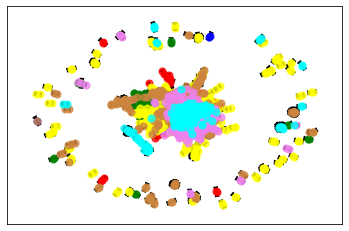

In [7]:
from torch_geometric.utils import convert
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import Planetoid

plt.figure()

dataset = Planetoid(root='', name='Cora')
cora = to_networkx(dataset.data)
pos = nx.layout.spring_layout(cora)


node_color = ["red","blue","green","yellow","peru","violet","cyan"] 
node_label = np.array(list(cora.nodes)) 
node_classes = dataset.data.y.data.numpy()
for i in np.arange(len(np.unique(node_classes))):
    node_list = node_label[node_classes == i]
    nx.draw_networkx_nodes(cora, pos, nodelist=list(node_list),
                           node_size=50,  
                           node_color=node_color[i], 
                           alpha=0.8)
nx.draw_networkx_edges(cora, pos,width=1,edge_color="black")

plt.show()